In [2]:
#importing libraries
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
#loading the dataset
voting_data = pd.read_csv("/content/house_votes_84.csv")
voting_data.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-adi,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,target
0,1,2,1,2,2,2,1,1,1,2,0,2,2,2,1,2,1
1,1,2,1,2,2,2,1,1,1,1,1,2,2,2,1,0,1
2,0,2,2,0,2,2,1,1,1,1,2,1,2,2,1,1,0
3,1,2,2,1,0,2,1,1,1,1,2,1,2,1,1,2,0
4,2,2,2,1,2,2,1,1,1,1,2,0,2,2,2,2,0


In [5]:
class DecisionTree():

  WHITE_NODE = "white_node"

  def _class_probabilities(self, y):

    """
    this function computes probabilities of unique classes in y
    for e.g. the target label has two classes '1' and '0', so it will
    compute the probability of both these classes

    Parameter description:
    y: the attribute for which the probability has to be computed

    returns: a list containing probability for each unique class in y
    """

    number_of_unique_classes = len(y)
    unique_class_counts = y.value_counts()
    return [class_count/number_of_unique_classes for class_count in unique_class_counts]

  def _entropy(self, y) -> float:

    """
    this function gets probabilities of unique classes in y by
    making a call to function _class_probabilities and then computes
    entropy for y
    for e.g. the target label has two classes '1' and '0', so it will
    compute the entropy of y

    Parameter description:
    y: the attribute for which entropy has to be computed

    returns: float value representing the entropy of class y
    """

    probabilities = self._class_probabilities(y)
    return sum([-p * np.log2(p) for p in probabilities if p>0])

  def _information_gain(self, y, y_subsets) -> float:

    """
    this function gets entropy of both children and parent
    and calculates the information gain
    for e.g. it computes the information gain difference between the
    parent(target) and child(handicapped-infants)

    Parameter description:
    y: the attribute which serves as parent for information gain calculation (e.g. - target)
    y_subsets: the subsets of a particular feature having y values corresponding
    to each unique class present in feature (e.g. - if the selected feature is
    handicapped-infants then it should have subsets for 0,1,2)

    returns: float value representing the information gained
    """

    entropy_parent = self._entropy(y)
    entropy_children = 0
    total_samples = len(y)
    for y_subset in y_subsets:
      subset_size = len(y_subset)
      if subset_size == 0:
        continue
      entropy_children += (subset_size / total_samples) * self._entropy(y_subset)
    gain = entropy_parent - entropy_children
    return gain

  def _best_split(self,X,y,feature_list):

    """
    this function retrieves the list of features that have not yet been assigned
    to a node. It iterates over each of these features to calculate the information
    gain associated with them. Subsequently, it determines the best feature by
    selecting the one with the highest information gain.
    for e.g. it computes the information gain difference between the
    parent(target) and each child(e.g. handicapped-infants, water-project-cost-sharing,..)
    to decide the best feature to split on

    Parameter description:
    X: feature columns dataframe
    y: the target column
    feature_list: features that have not been assigned

    returns: feature with highest information gain
    """

    best_gain = -1
    best_feature = None

    num_samples = X.shape[0]
    num_classes = len(np.unique(y))

    for feature in feature_list:
      y_subsets = list()
      unique_values = np.unique(X[feature][:])
      for value in unique_values:
        y_subset = y[X[feature] == value]
        y_subsets.append(y_subset)
      info_gain = self._information_gain(y, y_subsets)
      if info_gain > best_gain:
        best_gain = info_gain
        best_feature = feature
    return best_feature

  def _split_tree(self, feature_to_split_on, X, y):
    """
    this function splits the decision tree based on the specified feature to split on.
    It creates a subtree for each unique value of the specified feature if it's a leaf node
    and determines if the class is impure and marks it "white_node"

    Parameter description:
    feature_to_split_on: The feature to split the tree on.
    X: feature columns dataframe
    y: the target column.

    returns:
    tree: A dictionary representing the split decision tree.
    X: Updated DataFrame after splitting based on the specified feature.
    y: Updated target dataframe after splitting based on the specified feature.
    """
    tree = {}
    y_subsets = dict()
    feature_unique_values = np.unique(X[feature_to_split_on][:])
    for feature_value in feature_unique_values:
      y_subset = y[X[feature_to_split_on] == feature_value]
      y_subsets[feature_value] = y_subset

    for value in y_subsets.keys():
      list_of_values = y_subsets[value]
      count = len(list_of_values)
      target_column_name = list_of_values.columns[0]
      y_unique_values = list_of_values[target_column_name].value_counts().to_dict()
      assigned_to_node = False
      for y_class in y_unique_values.keys():
          if y_unique_values[y_class] == count:
            tree[value] = y_class
            y = y[X[feature_to_split_on] != value]
            X = X[X[feature_to_split_on] != value]
            assigned_to_node = True
      if not assigned_to_node:
        tree[value] = self.WHITE_NODE

    return tree, X, y

  def _build_tree(self, root, X, y, previous_feature_value, feature_list, depth_prevention=False):
    """
    this function constructs the decision tree recursively by choosing the best
    feature to split the dataset and continues the process until a stopping condition
    is met.
    Note: 1. If depth_prevention is True (which in this case is not), the function
             stops expanding the tree if a 85% of the instances associated with a
             node belong to a particular class
          2. If there are no more features to split on and consequently the
              best_feature is None, the node is assigned the majority class

    Parameter description:
    root: the root node of the decision tree being constructed
    X: input features dataset
    y: target variable dataset
    previous_feature_value: value of the previous feature in the decision tree
    feature_list: list of features available for splitting
    depth_prevention: A flag indicating whether to prevent further depth in the
                      tree by assigning the class with 85% or more instances to
                      the node. Defaults to False

    returns: None
    """

    threshold_percentage = 0.85
    target = y.columns[0]

    if X.shape[0] != 0:
      if depth_prevention == True:
        total_counts = len(y)
        y_value_counts = y[target].value_counts()
        frequent_values = y_value_counts[y_value_counts>=(threshold_percentage*total_counts)]
        if len(frequent_values)==1:
          frequent_value = frequent_values.index[0]
          root[previous_feature_value] = y[target].value_counts().idxmax()
          return

      best_feature = self._best_split(X,y,feature_list)

      if best_feature is None:
        root[previous_feature_value] = y[target].value_counts().idxmax()
        return

      feature_list.remove(best_feature)
      tree, X, y = self._split_tree(best_feature, X, y)
      next_root = None

      if previous_feature_value == None:
        root[best_feature] = tree
        next_root = root[best_feature]
      else:
        root[previous_feature_value] = dict()
        root[previous_feature_value][best_feature] = tree
        next_root = root[previous_feature_value][best_feature]

      for feature, value in list(next_root.items()):
        if value == self.WHITE_NODE:
          y_filtered = y[X[best_feature] == feature]
          X_filtered = X[X[best_feature] == feature]
          self._build_tree(next_root, X_filtered, y_filtered, feature, feature_list,depth_prevention)

  def _fit(self, X, y, depth_prevention=False):
    """
    fits a decision tree model to the given dataset. It utilizes the `_build_tree`
    method to recursively build the tree structure.

    Parameter description:
    X: input features dataset
    y: target variable dataset
    depth_prevention: a flag indicating whether to prevent further depth in the tree
                      Defaults to False

    returns: the constructed decision tree
    """
    tree = {}
    self._build_tree(tree, X, y, None, X_train.columns.tolist(), depth_prevention)
    return tree

  def _make_prediction(self, tree_structure, input_instance):
    """
    this function makes a prediction using the provided decision tree structure
    and input instance. It traverses the decision tree structure until
    it reaches a leaf node and returns the prediction. It uses the input instance
    to follow the appropriate path down the tree.

    Parameter description:
    tree_structure: decision tree structure.
    input_instance: the input instance for which the prediction is to be made

    returns: the predicted value.
    """
    while isinstance(tree_structure, dict):
        first_node = list(tree_structure.keys())[0]
        feature_value = input_instance[first_node]
        if feature_value in tree_structure[first_node]:
            tree_structure = tree_structure[first_node][feature_value]
        else:
            return None
    return tree_structure

  def _evaluate(self, tree, test_set, label):
    """
    this function evaluates the model's accuracy by comparing the predicted
    labels with the true labels.

    Parameter description:
    tree: decision tree structure
    test_set: dataset used for testing
    label: true labels corresponding to the test set

    returns: The accuracy of the decision tree model
    """
    correct_pred, wrong_pred = 0,0
    label_column_name = label.columns[0]
    for i in range(test_set.shape[0]):
      input_instance = test_set.iloc[i]
      model_output = self._make_prediction(tree, input_instance)
      if model_output == label[label_column_name].iloc[i]:
        correct_pred+=1
      else:
        wrong_pred+=1
      accuracy = correct_pred/(test_set.shape[0])
    return accuracy

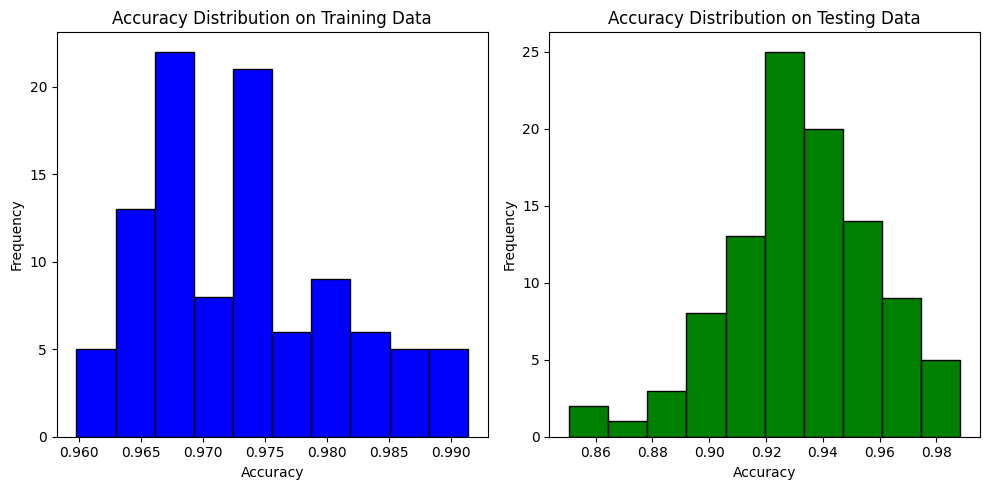

Mean training accuracy: 0.973448275862069
Standard deviation of training accuracy: 0.007086931659294202
Mean testing accuracy: 0.9320689655172413
Standard deviation of testing accuracy: 0.02710767907860068


In [ ]:
train_accuracies = []
test_accuracies = []

num_experiments = 100

for _ in range(num_experiments):

  #shuffling the voting data set
  shuffled_voting_data = shuffle(voting_data)

  #splitting the data into train and test set in the ratio 80:20
  X = shuffled_voting_data.drop('target', axis = 1)
  y = pd.DataFrame(shuffled_voting_data['target'], index = shuffled_voting_data.index)
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

  #building the decision tree model
  dt = DecisionTree()
  tree = dt._fit(X_train, y_train, False)

  #computing train accuracy for each trial
  train_accuracy = dt._evaluate(tree, X_train, y_train)
  train_accuracies.append(train_accuracy)

  #computing test accuracy for each trial
  test_accuracy = dt._evaluate(tree, X_test, y_test)
  test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(train_accuracies, bins=10, color='blue', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Distribution on Training Data')

plt.subplot(1, 2, 2)
plt.hist(test_accuracies, bins=10, color='green', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Distribution on Testing Data')

plt.tight_layout()
plt.show()

# Reporting mean accuracy and standard deviation
print("Mean training accuracy:", np.mean(train_accuracies))
print("Standard deviation of training accuracy:", np.std(train_accuracies))
print("Mean testing accuracy:", np.mean(test_accuracies))
print("Standard deviation of testing accuracy:", np.std(test_accuracies))

#**Extra Credit Question**

QE.2

Setting the **depth_prevention** to **True** inside _build_tree function to prevent further depth in the tree. The function stops expanding the tree if a 85% of the instances associated with a node belong to a particular class.

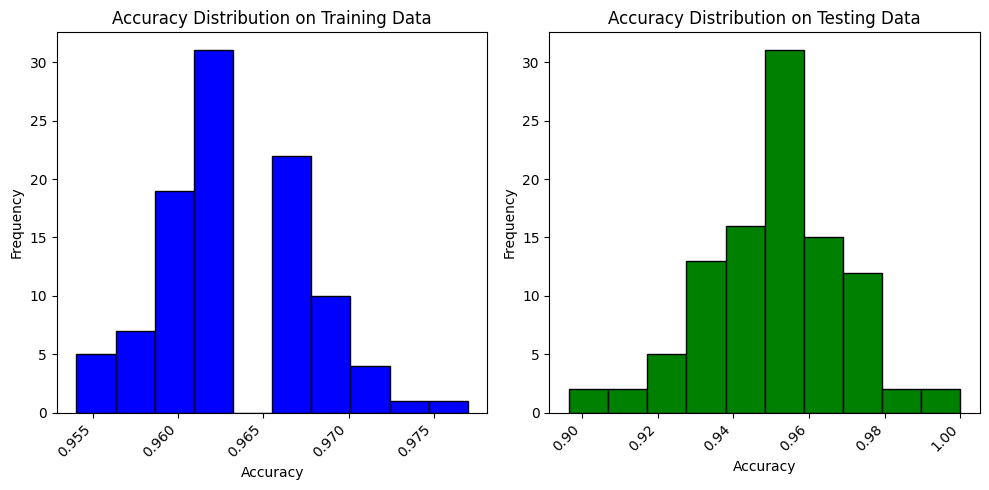

Mean training accuracy: 0.9630747126436782
Standard deviation of training accuracy: 0.004346115937429369
Mean testing accuracy: 0.9514942528735633
Standard deviation of testing accuracy: 0.020013207424010932


In [6]:
train_accuracies = []
test_accuracies = []

num_experiments = 100

for _ in range(num_experiments):

  #shuffling the voting data set
  shuffled_voting_data = shuffle(voting_data)

  #splitting the data into train and test set in the ratio 80:20
  X = shuffled_voting_data.drop('target', axis = 1)
  y = pd.DataFrame(shuffled_voting_data['target'], index = shuffled_voting_data.index)
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

  #building the decision tree model; setting depth_prevention to True
  dt = DecisionTree()
  tree = dt._fit(X_train, y_train, True)

  #computing train accuracy for each trial
  train_accuracy = dt._evaluate(tree, X_train, y_train)
  train_accuracies.append(train_accuracy)

  #computing test accuracy for each trial
  test_accuracy = dt._evaluate(tree, X_test, y_test)
  test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(train_accuracies, bins=10, color='blue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Distribution on Training Data')

plt.subplot(1, 2, 2)
plt.hist(test_accuracies, bins=10, color='green', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Distribution on Testing Data')

plt.tight_layout()
plt.show()

# Reporting mean accuracy and standard deviation
print("Mean training accuracy:", np.mean(train_accuracies))
print("Standard deviation of training accuracy:", np.std(train_accuracies))
print("Mean testing accuracy:", np.mean(test_accuracies))
print("Standard deviation of testing accuracy:", np.std(test_accuracies))